In [1]:

import torch.nn.functional as F
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
import math
import pydicom
import numpy as np
import torch, os
import torch.nn.functional as F
from torch import nn, einsum
from torch.utils.data import Dataset
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from PIL import Image
import glob
from torchsummary import summary
from torchvision.transforms import Compose, Resize, ToTensor

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
import matplotlib.pyplot as plt

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def normalize(x):
    return (x - x.mean()) / (x.max() - x.min())
#dataset for cbct dicom
def load_dcm(image_path):
#     image_data=[]
#     for i in range(len(image_path)):
    ds=pydicom.dcmread(image_path)
    ww=ds.WindowWidth
    wc=ds.WindowCenter
    slope = ds.RescaleSlope
    intercept = ds.RescaleIntercept

    ymin = 0
    ymax = 255

    pixel_array = ds.pixel_array * slope + intercept

    # linear exact array
    linear_exact_array = np.zeros(pixel_array.shape)

    linear_exact_array_less_idx = pixel_array <= (wc - ww/2)
    linear_exact_array_large_idx = pixel_array > (wc + ww/2)
    linear_exact_array = ((pixel_array - wc)/ww + 0.5) * (ymax - ymin) + ymin
    linear_exact_array[linear_exact_array_less_idx] = ymin
    linear_exact_array[linear_exact_array_large_idx] = ymax
    linear_exact_array = linear_exact_array.astype(np.uint8)        
    #add channel

    ct=np.expand_dims(linear_exact_array,axis=0)
    ct = np.transpose(ct, (2, 1, 0))
    ct = np.clip(ct, -200, 2000)
    # ct=normalize(ct)        
    #because ndarray does not support uint16 , must change to float
    ct=ct.astype(float)

    return ct #image_data

import numpy as np

# Load data from .npy file
data = np.load('./result.npy')

# Create an empty numpy array to store the loaded data
data_load = np.empty((len(data), 2), dtype=object)

# Load each pair of data and store it in the numpy array
for i, pair in enumerate(data):
    data_load[i, 0] = load_dcm(pair[0])
    data_load[i, 1] = load_dcm(pair[1])
    
# print(len(data_load))

In [3]:
from torch.utils.data import Dataset,DataLoader
import numpy as np
from PIL import Image
# import cv2
import random

class ImageDatasetLoader(Dataset):
    def __init__(self, mode='train', transformers=None, test_indices=[17000,17010,17020,17030,17040,17060,17070,17080,17090,17100,
                                                                      18000,18100,18200,18300,18400,18500,18600,18700,18800,18900, 
                                                                      19000,19050,19150,19250,19350,19450,19550,19650,19750,19850,
                                                                      19950,20050,20150,20250,20350,20450,20550,20650,20750,20850,
                                                                      20950,22030,22130,22230,22330,22430,22530,22630,22730,22830,
                                                                      23070,23170,23270,23370,23470,23570,23670,23770,23870,23970,
                                                                     ]):
        self.mode = mode
        self.transform = transformers
        
        # Assuming you have the complete dataset in the 'data_load' variable
        total_samples = len(data_load)
        
        if mode == 'train':
            self.files_CBCT = data_load[0:17000, 0]
            self.files_sim = data_load[0:17000, 1]
        elif mode == 'train1':
            self.files_CBCT = data_load[0:17000, 0]
            self.files_sim = data_load[0:17000, 1]
        elif mode == 'test':
            if test_indices is None:
                # Randomly select 60 samples for the test set
                test_indices = random.sample(range(17000, total_samples), 60)
            self.files_CBCT = data_load[test_indices, 0]
            self.files_sim = data_load[test_indices, 1]
        elif mode == 'fid':
            self.files_CBCT = data_load[21704:24704, 0]
            self.files_sim = data_load[21704:24704, 1]
        elif mode == 'evl':
            self.files_CBCT = data_load[24000:24704, 0]
            self.files_sim = data_load[24000:24704, 1]
        # elif mode == 'evl':
        #     if test_indices is None:
        #         # Randomly select 60 samples for the test set
        #         test_indices = random.sample(range(17000, total_samples), 60)
        #     self.files_CBCT = data_load[test_indices, 0]
        #     self.files_sim = data_load[test_indices, 1]

        self.cbctnorm = transforms.Compose([
            transforms.ToTensor(),
        ])
        self.simctnorm = transforms.Compose([
            transforms.ToTensor(),
        ])
        self.alltransform = transforms.Compose([
            transforms.ToTensor(),
        ])
        
    def __len__(self):
        return len(self.files_sim)
    
    def __getitem__(self, index):
        file_A = self.files_CBCT[index]
        file_B = self.files_sim[index]
        if self.transform is not None:
            if self.mode == 'train': 
                img_A = self.alltransform(file_A)
                img_B = self.alltransform(file_B)
                file_cat = torch.cat((img_A, img_B, img_B), dim=0)
                img_cat = self.transform(file_cat)
                img_A, img_B, xx = torch.split(img_cat, [1, 1, 1], dim=0)
                img_A = self.cbctnorm(file_A)
                img_B = self.simctnorm(file_B)
            else:
                img_A = self.cbctnorm(file_A)
                img_B = self.simctnorm(file_B)
        return img_A, img_B

import torchvision.transforms as transforms
import torch, os, sys
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam,AdamW
from tqdm import tqdm

import numpy as np
from PIL import Image
import torchvision.transforms as transforms

# Define the custom transform
class NumpyToPIL(object):
    def __call__(self, img):
        return Image.fromarray(np.uint8(img))
# Define your transforms
data_transform = transforms.Compose([
    # transforms.ToPILImage(),
    # transforms.CenterCrop(size=(350, 350)),  # crop the center part of the image with size 300x300
    # transforms.Resize(size=(384, 384)),  # resize the cropped image to 384x384
    transforms.RandomHorizontalFlip(),  # randomly flip the image horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(),  # randomly flip the image vertically with a probability of 0.5
    transforms.ColorJitter(brightness=0.1, contrast=0.2),  # randomly adjust brightness, contrast, saturation, and hue
    transforms.RandomRotation(degrees=15),  # randomly rotate the image by up to 15 degrees
    # transforms.RandomCrop(size=(300, /300)),  # randomly crop the image to size 300x300
    # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # randomly apply Gaussian blur
    # transforms.ToTensor(),  # convert the image to a PyTorch tensor
    # transforms.Normalize(0.5, 0.5, 0.5)
])
transforms_ = transforms.Compose([
    # transforms.ToTensor(),
    # transforms.Normalize(0.5, 0.5, 0.5)
])

In [4]:
import torchvision.transforms as transforms
import torch, os, sys
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam,AdamW
from tqdm import tqdm
transforms_ = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5, 0.5)
])

In [5]:
from __future__ import division
from __future__ import print_function
import time
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid, save_image

from tqdm import tqdm
from copy import deepcopy


In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.SiLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.drop = nn.Dropout(0.2)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        out = self.drop(out)
        return out
    
#next generation residual block
class rSoftMax(nn.Module):
    def __init__(self, radix, cardinality):
        super().__init__()
        assert radix > 0
        self.radix = radix
        self.cardinality = cardinality

    def forward(self, x):
        batch = x.size(0)
        if self.radix > 1:
            x = x.view(batch, self.cardinality, self.radix, -1).transpose(1, 2)
            x = F.softmax(x, dim=1)
            x = x.reshape(batch, -1)
        else:
            x = torch.sigmoid(x)
        return x

class Splat(nn.Module):
    def __init__(self, channels, radix, cardinality, reduction_factor=4):
        super(Splat, self).__init__()
        self.radix = radix
        self.cardinality = cardinality
        self.channels = channels
        inter_channels = max(channels*radix//reduction_factor, 32)
        self.fc1 = nn.Conv2d(channels//radix, inter_channels, 1, groups=cardinality)
#         self.bn1 = nn.BatchNorm2d(inter_channels)
        self.bn1 = nn.InstanceNorm2d(inter_channels)
        self.relu = nn.SiLU(inplace=True)
        self.fc2 = nn.Conv2d(inter_channels, channels*radix, 1, groups=cardinality)
        self.rsoftmax = rSoftMax(radix, cardinality)

    def forward(self, x):
        batch, rchannel = x.shape[:2]
        if self.radix > 1:
            splited = torch.split(x, rchannel//self.radix, dim=1)
            gap = sum(splited) 
        else:
            gap = x
        gap = F.adaptive_avg_pool2d(gap, 1)
        gap = self.fc1(gap)

        gap = self.bn1(gap)
        gap = self.relu(gap)

        atten = self.fc2(gap)
        atten = self.rsoftmax(atten).view(batch, -1, 1, 1)

        if self.radix > 1:
            attens = torch.split(atten, rchannel//self.radix, dim=1)
            out = sum([att*split for (att, split) in zip(attens, splited)])
        else:
            out = atten * x
        return out.contiguous()

In [7]:
class ds_conv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, 
                 dilation=[1,3,5], groups=1, bias=True, 
                 act_layer='nn.SiLU(True)', init='kaiming'):
        super().__init__()
        assert in_planes%groups==0
        assert kernel_size==3, 'only support kernel size 3 now'
        self.in_planes = in_planes
        self.out_planes = out_planes
        self.kernel_size = kernel_size
        self.stride = stride
        self.dilation = dilation
        self.groups = groups
        self.with_bias = bias
        
        self.weight = nn.Parameter(torch.randn(out_planes, in_planes//groups, kernel_size, kernel_size), requires_grad=True)
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_planes))
        else:
            self.bias = None
        self.act = eval(act_layer)
        self.init = init
        self._initialize_weights()

    def _initialize_weights(self):
        if self.init == 'dirac':
            nn.init.dirac_(self.weight, self.groups)
        elif self.init == 'kaiming':
            nn.init.kaiming_uniform_(self.weight)
        else:
            raise NotImplementedError
        if self.with_bias:
            if self.init == 'dirac':
                nn.init.constant_(self.bias, 0.)
            elif self.init == 'kaiming':
                bound = self.groups / (self.kernel_size**2 * self.in_planes)
                bound = math.sqrt(bound)
                nn.init.uniform_(self.bias, -bound, bound)
            else:
                raise NotImplementedError

    def forward(self, x):
        output = 0
        for dil in self.dilation:
            output += self.act(
                F.conv2d(
                    x, weight=self.weight, bias=self.bias, stride=self.stride, padding=dil,
                    dilation=dil, groups=self.groups,
                )
            )
        return output
class AtrousSelfAttention(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1, num_heads=2):
        super(AtrousSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = out_channels // num_heads
        self.query_conv = ds_conv2d(in_channels, out_channels, kernel_size)
#         self.key_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, out_channels,1)
        self.value_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
#         self.value_conv = nn.Conv2d(in_channels, out_channels, 1)
 
        self.dropout = nn.Dropout(0.2)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.query_conv.weight)
        nn.init.kaiming_uniform_(self.key_conv.weight)
        nn.init.kaiming_uniform_(self.value_conv.weight)
        nn.init.zeros_(self.query_conv.bias)
        nn.init.zeros_(self.key_conv.bias)
        nn.init.zeros_(self.value_conv.bias)

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        queries = self.query_conv(x).view(batch_size, self.num_heads, self.head_dim, height*width).permute(0, 1, 3, 2)
        keys = self.key_conv(x).view(batch_size, self.num_heads, self.head_dim, height*width).permute(0, 1, 2, 3)
        values = self.value_conv(x).view(batch_size, self.num_heads, self.head_dim, height*width).permute(0, 1, 3, 2)
        energy = torch.matmul(queries, keys)
        attention = torch.softmax(energy / self.head_dim**0.5, dim=-1)
#         attention = self.dropout(attention)
        out = torch.matmul(attention, values)
        out = out.permute(0, 1, 3, 2).contiguous().view(batch_size, -1, height, width)
        return out
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None,
                 out_features=None, act_layer=nn.GELU,
                 drop=0.2, with_depconv=True):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.with_depconv = with_depconv
        
        if self.with_depconv:
            self.fc1 = nn.Conv2d(
                in_features, hidden_features, 1, stride=1, padding=0, dilation=1, 
                groups=1, bias=True,
            )
            self.depconv = nn.Conv2d(
                hidden_features, hidden_features, 3, stride=1, padding=1, dilation=1, 
                groups=hidden_features, bias=True,
            )
            self.act = act_layer()
            self.fc2 = nn.Conv2d(
                hidden_features, out_features, 1, stride=1, padding=0, dilation=1, 
                groups=1, bias=True,
            )
        else:
            self.fc1 = nn.Linear(in_features, hidden_features)
            self.act = act_layer()
            self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        if self.with_depconv:
            x = self.fc1(x)
            x = self.depconv(x)
            x = self.act(x)
            x = self.drop(x)
            x = self.fc2(x)
            x = self.drop(x)
            return x
        else:
            x = self.fc1(x)
            x = self.act(x)
            x = self.drop(x)
            x = self.fc2(x)
            x = self.drop(x)
            return x

In [8]:
import math
import torch.nn as nn
import torch.nn.functional as F
import torch

class CSA(nn.Module):
    def __init__(self, in_dim, out_dim, num_heads, kernel_size=3, padding=1, stride=2,
                 qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        head_dim = out_dim // num_heads
        self.num_heads = num_heads
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.scale = qk_scale or head_dim**-0.5
        
        self.attn = nn.Linear(in_dim, kernel_size**4 * num_heads)
        self.attn_drop = nn.Dropout(attn_drop)

        self.unfold = nn.Unfold(kernel_size=kernel_size, padding=padding, stride=stride)
        self.pool = nn.AvgPool2d(kernel_size=stride, stride=stride, ceil_mode=True)
        
        self.csa_group = 1
        assert out_dim % self.csa_group == 0
        self.weight = nn.Conv2d(
            self.kernel_size*self.kernel_size*out_dim, 
            self.kernel_size*self.kernel_size*out_dim, 
            1, 
            stride=1, padding=0, dilation=1, 
            groups=self.kernel_size*self.kernel_size*self.csa_group, 
            bias=qkv_bias,
        )
        assert qkv_bias == False
        fan_out = self.kernel_size*self.kernel_size*self.out_dim
        fan_out //= self.csa_group
        self.weight.weight.data.normal_(0, math.sqrt(2.0 / fan_out)) # init
        
        self.proj = nn.Linear(out_dim, out_dim)
        self.proj_drop = nn.Dropout(proj_drop)
        
    def forward(self, x, v=None):
        x = x.permute(0, 2, 3, 1)
        B, H, W, _ = x.shape
        h, w = math.ceil(H / self.stride), math.ceil(W / self.stride)
        
        attn = self.pool(x.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        attn = self.attn(attn).reshape(
            B, h * w, self.num_heads, self.kernel_size * self.kernel_size,
            self.kernel_size * self.kernel_size).permute(0, 2, 1, 3, 4) # B,H,N,kxk,kxk
        attn = attn * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        v = x.permute(0, 3, 1, 2) # B,C,H, W
        v = self.unfold(v).reshape(
            B, self.out_dim, self.kernel_size*self.kernel_size, h*w
        ).permute(0,3,2,1).reshape(B*h*w, self.kernel_size*self.kernel_size*self.out_dim, 1, 1)
        v = self.weight(v)
        v = v.reshape(B, h*w, self.kernel_size*self.kernel_size, self.num_heads, 
                      self.out_dim//self.num_heads).permute(0,3,1,2,4).contiguous() # B,H,N,kxk,C/H
        
        x = (attn @ v).permute(0, 1, 4, 3, 2)
        x = x.reshape(B, self.out_dim * self.kernel_size * self.kernel_size, h * w)
        x = F.fold(x, output_size=(H, W), kernel_size=self.kernel_size, 
                   padding=self.padding, stride=self.stride)

        x = self.proj(x.permute(0, 2, 3, 1))
        x = self.proj_drop(x)
        return x.permute(0, 3, 1, 2)


In [9]:
import torch
import torch.nn as nn
# class cross_attention(nn.Module):
#     def __init__(self, in_channels,num_heads=2, kernel_size=3, dilation=1):
#         super(cross_attention, self).__init__()
#         out_channels = in_channels
#         self.num_heads = num_heads
#         self.head_dim = out_channels // num_heads
#         self.query_conv = nn.Conv2d(in_channels, out_channels,3,1,1)
# #         self.key_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
#         self.key_conv = nn.Conv2d(in_channels, out_channels,1)
#         self.value_conv = nn.Conv2d(in_channels, out_channels, 1)
# #         self.value_conv = nn.Conv2d(in_channels, out_channels, 1)

#         self.reset_parameters()

#     def reset_parameters(self):
#         nn.init.kaiming_uniform_(self.query_conv.weight)
#         nn.init.kaiming_uniform_(self.key_conv.weight)
#         nn.init.kaiming_uniform_(self.value_conv.weight)
#         nn.init.zeros_(self.query_conv.bias)
#         nn.init.zeros_(self.key_conv.bias)
#         nn.init.zeros_(self.value_conv.bias)

#     def forward(self, x, k, v):
#         batch_size, channels, height, width = x.size()
#         queries = self.query_conv(x).view(batch_size, self.num_heads, self.head_dim, height*width).permute(0, 1, 3, 2)
#         keys = self.key_conv(k).view(batch_size, self.num_heads, self.head_dim, height*width).permute(0, 1, 2, 3)
#         values = self.value_conv(v).view(batch_size, self.num_heads, height*width, self.head_dim)
#         energy = torch.matmul(queries, keys)
#         attention = torch.softmax(energy / self.head_dim**0.5, dim=-1)
#         out = torch.matmul(attention, values)
#         out = out.permute(0, 1, 3, 2).contiguous().view(batch_size, -1, height, width)
#         return out
class cross_attention(nn.Module):
    def __init__(self,in_channels) :
        super(cross_attention, self).__init__()
        self.queryConv =nn.Sequential(nn.Conv2d(in_channels, in_channels,1,1), 
                                      nn.GroupNorm(in_channels//4,in_channels)) 
        self.keyConv = nn.Sequential(nn.Conv2d(in_channels,in_channels,1,1), 
                                     nn.GroupNorm(in_channels//4,in_channels)) 
        self.psiConv = nn.Sequential(
            nn.GroupNorm(in_channels//4,in_channels),
            nn.Conv2d(in_channels,1,1,1), 
            nn.SiLU()) 
    def forward(self, query, key):
        value = key
        key = self.keyConv(key)
        query = self.queryConv(query)
        psi = F.silu(key+query)
        psi = self.psiConv(psi)
        return value*psi




In [10]:
class SPADE(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(SPADE, self).__init__()
        self.norm = nn.GroupNorm(in_channels//4,in_channels)
        self.share = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding)
        self.conv_gamma = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding)
        self.conv_beta = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding)

    def forward(self, x, segmap):
        normalized = self.norm(x)
        seg_share  = self.share(F.silu(self.norm(segmap)))
        gamma = self.conv_gamma(F.silu(self.norm(seg_share)))
        #beta = F.silu(self.conv_beta(self.norm(x)))
        return (1 + gamma) * normalized #+ beta

class style_encoder(nn.Module):
    def __init__(self,in_channels,embed_dim ):
        super(style_encoder,self).__init__()
        self.embed_dim =embed_dim 
        self.styleconv1 = nn.Sequential(
            nn.Conv2d(1, self.embed_dim, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(self.embed_dim//4,self.embed_dim),
            nn.SiLU(inplace=True)
        )
        self.styleconv2 = nn.Sequential(
            nn.Conv2d(self.embed_dim, self.embed_dim, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(self.embed_dim//4,self.embed_dim),
            nn.SiLU(inplace=True)
        )
            
        self.styleconv3 = nn.Sequential(
            nn.Conv2d(self.embed_dim, self.embed_dim*2, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(self.embed_dim//2,self.embed_dim*2),
            nn.SiLU(inplace=True)
        )
        self.styleconv4 = nn.Sequential(
            nn.Conv2d(self.embed_dim*2, self.embed_dim*4, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(self.embed_dim//2,self.embed_dim*4),
            nn.SiLU(inplace=True)
        )
        self.upUpsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.styleup4 = nn.Sequential(
            nn.Conv2d(self.embed_dim*6,self.embed_dim*2, 3,1,1),
            nn.GroupNorm(self.embed_dim//2,self.embed_dim*2),
            nn.SiLU(inplace=True)
        )
        self.styleup3 = nn.Sequential(
            nn.Conv2d(self.embed_dim*3,self.embed_dim*1, 3,1,1),
            nn.GroupNorm(self.embed_dim//4,self.embed_dim*1),
            nn.SiLU(inplace=True)
        )
        self.styleup2 = nn.Sequential(
            nn.Conv2d(self.embed_dim*2,self.embed_dim*1,3,1,1),
            nn.GroupNorm(self.embed_dim//4,self.embed_dim*1),
            nn.SiLU(inplace=True)
        )
        
    def forward (self,x):
        x1 = self.styleconv1(x)
        x2 = self.styleconv2(x1)
        x3 = self.styleconv3(x2)
        x4 = self.styleconv4(x3)
        
        x5 = self.upUpsample(x4)
        x5 = torch.cat((x5,x3),dim=1)
        x5 = self.styleup4(x5)
        
        x6 = self.upUpsample(x5)
        x6 = torch.cat((x6,x2),dim=1)
        x6 = self.styleup3(x6)
        
        x7 = self.upUpsample(x6)
        x7 = torch.cat((x7,x1),dim=1)
        x7 = self.styleup2(x7)
        
        return x7, x6, x5, x4
        
        
        
        
    


In [11]:
class BasicConv(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride, bias=True, norm=False, relu=True, transpose=False):
        super(BasicConv, self).__init__()
        if bias and norm:
            bias = False

        padding = kernel_size // 2
        layers = list()
        if transpose:
            padding = kernel_size // 2 -1
            layers.append(nn.ConvTranspose2d(in_channel, out_channel, kernel_size, padding=padding, stride=stride, bias=bias))
        else:
            layers.append(
                nn.Conv2d(in_channel, out_channel, kernel_size, padding=padding, stride=stride, bias=bias))
        if norm:
            layers.append(nn.BatchNorm2d(out_channel))
        if relu:
            layers.append(nn.ReLU(inplace=True))
        self.main = nn.Sequential(*layers)

    def forward(self, x):
        return self.main(x)


class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, norm=False):
        super(ResBlock, self).__init__()
        self.main = nn.Sequential(
            BasicConv(in_channel, out_channel, kernel_size=3, stride=1, norm=norm, relu=True),
            BasicConv(out_channel, out_channel, kernel_size=3, stride=1, norm=norm, relu=False)
        )

    def forward(self, x):
        return self.main(x) + x

In [12]:
class TGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.overlappatch_size=48
        self.patch_size = 96
        self.num_patch=(384//self.patch_size)
        self.num_patches=self.num_patch**2
        self.embed_dim = 64
        
        
        self.patches = nn.Sequential(
            nn.Conv2d(1, self.embed_dim,  kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(self.embed_dim//4,self.embed_dim),
            nn.SiLU(inplace=True),
        )
        self.down1 = nn.Sequential(
            nn.Conv2d(self.embed_dim, self.embed_dim,  kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(self.embed_dim//4,self.embed_dim),
            nn.SiLU(inplace=True),
        )
        
        
        # self.cross_attention1 = cross_attention(in_channels=self.embed_dim, num_heads=2)
        self.cross_attention1 = cross_attention(in_channels=self.embed_dim)
        self.attn1 = CSA(in_dim=self.embed_dim, out_dim=self.embed_dim, num_heads=2)
        self.pos_embed1 = nn.Parameter(torch.zeros(1, self.embed_dim, self.patch_size,self.patch_size))
        self.norm1 = nn.GroupNorm(self.embed_dim//4,self.embed_dim)
        self.mlp1 = Mlp(self.embed_dim,self.embed_dim*4)
        # self.ResidualBlock1 = ResidualBlock(self.embed_dim,self.embed_dim)
        
        self.down2 = nn.Sequential(
            nn.Conv2d(self.embed_dim, self.embed_dim*2,  kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(32,self.embed_dim*2),
            nn.SiLU(inplace=True),
        )
        
        # self.cross_attention2 = cross_attention(in_channels=self.embed_dim*2, num_heads=2)
        self.cross_attention2 = cross_attention(in_channels=self.embed_dim*2)
        self.attn2 = AtrousSelfAttention(self.embed_dim*2, self.embed_dim*2, kernel_size=3, dilation=1, num_heads=4)
        self.pos_embed2 = nn.Parameter(torch.zeros(1, self.embed_dim*2, self.patch_size//2, self.patch_size//2))
        self.norm2 =nn.GroupNorm(32,self.embed_dim*2)
        self.mlp2 = Mlp(self.embed_dim*2,self.embed_dim*2*8)
        # self.ResidualBlock2 = ResidualBlock(self.embed_dim*2,self.embed_dim*2)

        
        self.down3 = nn.Sequential(
            nn.Conv2d(self.embed_dim*2, self.embed_dim*4, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(32,self.embed_dim*4),
            nn.SiLU(inplace=True),
        )
        
        # self.cross_attention3 = cross_attention(in_channels=self.embed_dim*4, num_heads=2)
        self.cross_attention3 = cross_attention(in_channels=self.embed_dim*4)
        self.attn3 = AtrousSelfAttention(self.embed_dim*4, self.embed_dim*4, kernel_size=3, dilation=1, num_heads=4)
        self.pos_embed3 = nn.Parameter(torch.zeros(1, self.embed_dim*4, self.patch_size//4, self.patch_size//4))
        self.norm3 = nn.GroupNorm(32,self.embed_dim*4)
        self.mlp3 = Mlp(self.embed_dim*4,self.embed_dim*4*4)
        # self.ResidualBlock3 = ResidualBlock(self.embed_dim*4,self.embed_dim*4)

        
        self.down4 = nn.Sequential(
            nn.Conv2d(self.embed_dim*4, self.embed_dim*8,  kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(32,self.embed_dim*8),
            nn.SiLU(inplace=True),
        )
        
        # self.cross_attention4 = cross_attention(in_channels=self.embed_dim*1, num_heads=2)
        self.cross_attention4 = cross_attention(in_channels=self.embed_dim*1)
        self.attn4 = AtrousSelfAttention(self.embed_dim*8, self.embed_dim*8, kernel_size=3, dilation=1, num_heads=4)
        self.pos_embed4 = nn.Parameter(torch.zeros(1, self.embed_dim*8, self.patch_size//8, self.patch_size//8))
        self.norm4 = nn.GroupNorm(self.embed_dim//2,self.embed_dim*8)
        self.mlp4 = Mlp(self.embed_dim*8,self.embed_dim*8*4)
        # self.ResidualBlock4 = ResidualBlock(self.embed_dim*8,self.embed_dim*8)
#         self.ResidualBlock4 = Splat(self.embed_dim*8,2,8)

        self.upUpsample = nn.Upsample(scale_factor=2, mode='nearest')
        
        # self.threethree = SPADE(self.embed_dim*4, self.embed_dim*4)
        self.con3 = nn.Sequential(
            nn.GroupNorm(32,self.embed_dim*8),
            nn.SiLU(True),
            nn.Conv2d(self.embed_dim*8,self.embed_dim*4, kernel_size=3, padding=1, stride=1),
        )
        self.con33 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.GroupNorm(32,self.embed_dim*8),
            nn.SiLU(True),
            nn.Conv2d(self.embed_dim*8,self.embed_dim*4, kernel_size=1),
            # nn.Conv2d(self.embed_dim*8,self.embed_dim*4, kernel_size=1),
             nn.Dropout(0.2)
        )
        # self.con33 = nn.Sequential(
        #     nn.GroupNorm(32,self.embed_dim*8),
        #     nn.SiLU(True),
        #     nn.ConvTranspose2d(self.embed_dim*8, self.embed_dim*4, kernel_size=4, padding=1, stride=2, bias=False),
        #     # nn.Conv2d(self.embed_dim*8,self.embed_dim*4, kernel_size=1),
        #      nn.Dropout(0.2)
        # )
            
        self.con2 = nn.Sequential(
            nn.GroupNorm(32,self.embed_dim*4),
            nn.SiLU(True),
            nn.Conv2d(self.embed_dim*4,self.embed_dim*2, kernel_size=3, padding=1, stride=1),
            
        )
        self.con22 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.GroupNorm(32,self.embed_dim*12),
            nn.SiLU(True),
            nn.Conv2d(self.embed_dim*12, self.embed_dim*2, kernel_size=3, padding=1, stride=1, bias=True),
            nn.Dropout(0.2)
            
        )
#         self.con22 = nn.Sequential(
#             nn.GroupNorm(32,self.embed_dim*12),
#             nn.SiLU(True),
#             nn.ConvTranspose2d(self.embed_dim*12, self.embed_dim*2, kernel_size=4, padding=1, stride=2, bias=False),
#             nn.Dropout(0.2)
            
#         )

        
        #48->96

        self.oneone =SPADE(self.embed_dim*1, self.embed_dim*1)
        self.con11 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.GroupNorm(32,self.embed_dim*10),
            nn.SiLU(True),
            nn.Conv2d(self.embed_dim*10, self.embed_dim*1,kernel_size=3, padding=1, stride=1, bias=True),
            nn.Dropout(0.2)
        )
        # self.con11 = nn.Sequential(
        #     nn.GroupNorm(32,self.embed_dim*10),
        #     nn.SiLU(True),
        #     nn.ConvTranspose2d(self.embed_dim*10, self.embed_dim*1, kernel_size=4, padding=1, stride=2, bias=False),
        #     nn.Dropout(0.2)
        # )
        self.con1 = nn.Sequential(
            nn.GroupNorm(32,self.embed_dim*2),
            nn.SiLU(True),
            nn.Conv2d(self.embed_dim*2,self.embed_dim*1, kernel_size=1),
        )
        # self.con11 = nn.Conv2d(self.embed_dim*2,self.embed_dim*1, kernel_size=3, stride=1, padding=1)
        

        self.upup =  SPADE(self.embed_dim*1, self.embed_dim*1)
        self.conupup =  nn.Conv2d(self.embed_dim*1,self.embed_dim*1, kernel_size=3, stride=1, padding=1)
        self.conupupnorm = nn.GroupNorm(self.embed_dim//4,self.embed_dim)
        
        # self.transup = nn.Sequential(
        #     nn.GroupNorm(32,self.embed_dim*5),
        #     nn.SiLU(True),
        #     nn.ConvTranspose2d(self.embed_dim*5, self.embed_dim*5, kernel_size=4, padding=1, stride=2, bias=False),
        #     nn.Dropout(0.2)
        # )
        self.transup = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.GroupNorm(32,self.embed_dim*5),
            nn.SiLU(True),
            nn.Conv2d(self.embed_dim*5, self.embed_dim*5,  kernel_size=3, stride=1, padding=1, bias=True),
            nn.Dropout(0.2)
        )
        
        self.conup = nn.Sequential(
            nn.GroupNorm(32,self.embed_dim*6),
            nn.SiLU(True),
            nn.Conv2d(self.embed_dim*6,self.embed_dim*1, kernel_size=1, bias=True),
        )
        self.transout = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.GroupNorm(32,self.embed_dim*2),
            nn.SiLU(True),
            nn.Conv2d(self.embed_dim*2, self.embed_dim*1,kernel_size=3, stride=1, padding=1, bias=True),
            nn.Dropout(0.2)
        )
        
        self.output = nn.Sequential(
            nn.SiLU(inplace=True),
            nn.Conv2d(self.embed_dim*1, 1, 3,1,1, bias=True),
            # nn.Tanh(),
        )   
        
        self.gelu=nn.GELU()
        drop_path=0.2
        self.drop_path = DropPath(
            drop_path) if drop_path > 0. else nn.Identity()
        self.transformer_layer = 2
        self.style = style_encoder(1,self.embed_dim)

        
    def forward(self,x,style):
        
        style1, style2, style3, style4 = self.style(style)
        
        # x_deblur = self.deblur(x)
        #input 1*384*384-> 16*96*96
        x1 = self.patches(x)
        x2t = self.down1(x1)
        #x2r = self.ResidualBlock1(x2t)
        x2 = x2t + self.pos_embed1
        for i in range(self.transformer_layer):
            x2 = x2 + self.drop_path(self.attn1(self.norm1(x2)))
            x2 = F.silu(x2)
        x2 = x2 + self.drop_path(self.mlp1(self.norm1(x2)))
        
        #16*96*96 -> 64*48*48
        x3t = self.down2(x2)
        #x3r = self.ResidualBlock2(x3t)
        x3 = x3t + self.pos_embed2
        for i in range(self.transformer_layer):
            x3 = x3 + self.drop_path(self.attn2(self.norm2(x3)))
            x3 = F.silu(x3)
        x3 = x3 + self.drop_path(self.mlp2(self.norm2(x3)))

        
        #64*48*48 ->256*24*24
        x4t = self.down3(x3)
        #x4r = self.ResidualBlock3(x4t)
        x4 = x4t + self.pos_embed3
        for i in range(self.transformer_layer):
            x4 = x4 + self.drop_path(self.attn3(self.norm3(x4)))
            x4 = F.silu(x4)
        x4 = x4 + self.drop_path(self.mlp3(self.norm3(x4)))

        x5t = self.down4(x4)
        #x5r = self.ResidualBlock4(x5t)
        x5 = x5t + self.pos_embed4
        for i in range(self.transformer_layer):
            x5 = x5 + self.drop_path(self.attn4(self.norm4(x5)))
            x5 = F.silu(x5)
        x5 = x5 + self.drop_path(self.mlp4(self.norm4(x5)))
        
        # x6 = self.upUpsample(x5)
        x6 = self.con33(x5)
        # x4_cross = self.cross_attention3(x6,x4,x4)
        x4_cross = self.cross_attention3(style4,x6)
        x6_cat = torch.cat((x6,x4_cross),dim=1)
        x6_cat1 = self.con3(x6_cat)
        # x6_cat_cross = self.cross_attention3(x6_cat1,style4)
        x6_cat_cross = self.cross_attention3(x6_cat1,x4)
        x6_cat = torch.cat((x6_cat1,x6_cat1,x6_cat_cross),dim=1)
        # x6_cat = x6_cat1 +  F.silu(self.norm3(self.con33(x6_cat)))
        
        # x7 = self.upUpsample(x6_cat)
        x7 = self.con22(x6_cat)
        x3_cross = self.cross_attention2(style3,x7)
        x7_cat = torch.cat((x7,x3_cross),dim=1)
        x7_cat1 = self.con2(x7_cat)
        # x7_cat_cross = self.cross_attention2(x7_cat1,style3)
        x7_cat_cross = self.cross_attention2(x7_cat1,x3)
        x7_cat = torch.cat((x7_cat1,x7_cat1,x7_cat1,x7_cat_cross,x7_cat_cross),dim=1)
        # x7_cat = x7_cat1 + F.silu(self.norm2(self.con22(x7_cat)))
        
        # x8 = self.upUpsample(x7_cat)
        x8 = self.con11(x7_cat)
        # x2_cross = self.cross_attention1(x8,x2,x2)
        x2_cross = self.cross_attention1(x8,style2)
        x8_cat = torch.cat((x8,x2_cross),dim=1)
        x8_cat1 = self.con1(x8_cat)

        # x8_cat_cross = self.cross_attention1(x8_cat1,style2)
        x8_cat_cross = self.cross_attention1(x8_cat1,x2)
        x8_cat = torch.cat((x8_cat1,x8_cat1,x8_cat_cross,x8_cat_cross,x8_cat_cross),dim=1)
        # x8_cat = x8_cat1 + F.silu(self.norm1(self.con11(x8_cat)))
        
        x9 = self.transup(x8_cat)
        x9_cat = torch.cat((x9,style1),dim=1)
        x9_cat = self.conup(x9_cat)
        # x9_cat_cross = self.cross_attention4(x9_cat,style1)
        x9_cat_cross = self.cross_attention4(x9_cat,x1)

        x9_cat1 = torch.cat((x9_cat,x9_cat_cross),dim=1)
        
        x11 = self.transout(x9_cat1)
        x11 = self.output(x11)
        return x11




In [13]:
#FPSE discriminator 
class TDiscriminator(nn.Module):
    def __init__(self, input_nc=1, nf=64, label_nc=1):
        super(TDiscriminator, self).__init__()
        # bottom-up pathway
        
        self.enc1 = nn.Sequential(
            nn.Conv2d(input_nc, nf, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(nf//4,nf),
            nn.SiLU(True))
        self.enc2 = nn.Sequential(
            nn.Conv2d(nf, nf*2, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(32,nf*2),
            nn.SiLU(True))
        self.enc3 = nn.Sequential(
            nn.Conv2d(nf*2, nf*4, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(32,nf*4),
            nn.SiLU(True))
        self.enc4 = nn.Sequential(
            nn.Conv2d(nf*4, nf*8, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(32,nf*8),
            nn.SiLU(True))
        self.enc5 = nn.Sequential(
            nn.Conv2d(nf*8, nf*8, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(32,nf*8),
            nn.SiLU(True))

        # top-down pathway
        self.lat2 = nn.Sequential(
            nn.Conv2d(nf*2, nf*4, kernel_size=1),
            nn.GroupNorm(32,nf*4),
            nn.SiLU(True))
        self.lat3 = nn.Sequential(
            nn.Conv2d(nf*4, nf*4, kernel_size=1),
            nn.GroupNorm(32,nf*4),
            nn.SiLU(True))
        self.lat4 = nn.Sequential(
            nn.Conv2d(nf*8, nf*4, kernel_size=1),
            nn.GroupNorm(32,nf*4),
            nn.SiLU(True))
        self.lat5 = nn.Sequential(
            nn.Conv2d(nf*8, nf*4, kernel_size=1),
            nn.GroupNorm(32,nf*4),
            nn.SiLU(True))
        
        # upsampling
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        
        # final layers
        self.final2 = nn.Sequential(
            nn.Conv2d(nf*4, nf*2, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(nf//2,nf*2),
            nn.SiLU(True))
        self.final3 = nn.Sequential(
            nn.Conv2d(nf*4, nf*2, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(nf//2,nf*2),
            nn.SiLU(True))
        self.final4 = nn.Sequential(
            nn.Conv2d(nf*4, nf*2, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(nf//2,nf*2),
            nn.SiLU(True))
    
        # true/false prediction and semantic alignment prediction
        self.tf = nn.Conv2d(nf*2, 1, kernel_size=1)
        self.seg = nn.Conv2d(nf*2, nf*2, kernel_size=1)
        self.embedding = nn.Conv2d(label_nc, nf*2, kernel_size=1)
        
        self.L1 = nn.L1Loss()

    def forward(self, fake_and_real_img, segmap):
        # bottom-up pathway
        feat11 = self.enc1(fake_and_real_img)  #384->192
        feat12 = self.enc2(feat11)   #192->96
        feat13 = self.enc3(feat12)   #96->48
        feat14 = self.enc4(feat13)  #48->24
        feat15 = self.enc5(feat14)   #24->12
        # top-down pathway and lateral connections
        feat25 = self.lat5(feat15)
        feat24 = self.up(feat25) + self.lat4(feat14)  #24
        feat23 = self.up(feat24) + self.lat3(feat13)  #48
        feat22 = self.up(feat23) + self.lat2(feat12)  #96
        # final prediction layers
        feat32 = self.final2(feat22)
        feat33 = self.final3(feat23)
        feat34 = self.final4(feat24)
        # Patch-based True/False prediction
        pred2 = self.tf(feat32)
        pred3 = self.tf(feat33)
        pred4 = self.tf(feat34)
        seg2 = self.seg(feat32)
        seg3 = self.seg(feat33)
        seg4 = self.seg(feat34)

        # intermediate features for discriminator feature matching loss
        feats = [feat12, feat13, feat14, feat15]

        # segmentation map embedding
        segemb = self.embedding(segmap)
        segemb = F.avg_pool2d(segemb, kernel_size=2, stride=2)
        segemb2 = F.avg_pool2d(segemb, kernel_size=2, stride=2)
        segemb3 = F.avg_pool2d(segemb2, kernel_size=2, stride=2)
        segemb4 = F.avg_pool2d(segemb3, kernel_size=2, stride=2)

        # semantics embedding discriminator score
        pred2 += torch.mul(segemb2, seg2).sum(dim=1, keepdim=True)
        pred3 += torch.mul(segemb3, seg3).sum(dim=1, keepdim=True)
        pred4 += torch.mul(segemb4, seg4).sum(dim=1, keepdim=True)

        # concat results from multiple resolutions
        results = [pred2, pred3, pred4]
            

        return [feats, results]

In [14]:
class GradientVariance(nn.Module):

    def __init__(self, patch_size):
        super(GradientVariance, self).__init__()
        self.patch_size = patch_size
        # Sobel kernel for the gradient map calculation
        self.kernel_x = torch.FloatTensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]).unsqueeze(0).unsqueeze(0).cuda()
        self.kernel_y = torch.FloatTensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]).unsqueeze(0).unsqueeze(0).cuda()
        # operation for unfolding image into non overlapping patches
        self.unfold = torch.nn.Unfold(kernel_size=(self.patch_size, self.patch_size), stride=self.patch_size)

    def forward(self, output, target):
        # calculation of the gradient maps of x and y directions
        gx_target = F.conv2d(target, self.kernel_x, stride=1, padding=1)
        gy_target = F.conv2d(target, self.kernel_y, stride=1, padding=1)
        gx_output = F.conv2d(output, self.kernel_x, stride=1, padding=1)
        gy_output = F.conv2d(output, self.kernel_y, stride=1, padding=1)

        # unfolding image to patches
        gx_target_patches = self.unfold(gx_target)
        gy_target_patches = self.unfold(gy_target)
        gx_output_patches = self.unfold(gx_output)
        gy_output_patches = self.unfold(gy_output)

        # calculation of variance of each patch
        var_target_x = torch.var(gx_target_patches, dim=1)
        var_output_x = torch.var(gx_output_patches, dim=1)
        var_target_y = torch.var(gy_target_patches, dim=1)
        var_output_y = torch.var(gy_output_patches, dim=1)

        # loss function as a MSE between variances of patches extracted from gradient maps
        gradvar_loss = F.mse_loss(var_target_x, var_output_x) + F.mse_loss(var_target_y, var_output_y)

        return gradvar_loss

from torchvision.utils import make_grid
from torchmetrics import PeakSignalNoiseRatio,StructuralSimilarityIndexMeasure,MetricCollection
Tensor = torch.cuda.FloatTensor if torch.cuda else torch.Tensor
def sample_images(real_A, real_B,G_AB,G_BA,epoch,figside=1.5,):
    assert real_A.size() == real_B.size(), 'The image size for two domains must be the same'
    
    G_AB.eval()
    G_BA.eval()
    
    real_A = real_A.type(Tensor)
    fake_B = G_AB(real_A).detach()
    real_B = real_B.type(Tensor)
    fake_A = G_BA(real_B).detach()
    psnrA = PeakSignalNoiseRatio(data_range=torch.max(real_A)-torch.min(real_A)).cuda()
    psnrB = PeakSignalNoiseRatio(data_range=torch.max(real_B)-torch.min(real_B)).cuda()
    ssim = StructuralSimilarityIndexMeasure().cuda()


    ans_ssim=ssim(fake_B,real_A)
    ans_psnr_toB=psnrB(fake_B,real_B)
    ans_psnr_toA=psnrA(fake_B,real_A)
    
    nrows = real_A.size(0)
    real_A = make_grid(real_A, nrow=nrows, normalize=True)
    fake_B = make_grid(fake_B, nrow=nrows, normalize=True)
    real_B = make_grid(real_B, nrow=nrows, normalize=True)
    fake_A = make_grid(fake_A, nrow=nrows, normalize=True)
    
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1).cpu().permute(1, 2, 0)
    
    plt.figure(figsize=(figside*nrows, figside*4))
    plt.imshow(image_grid)
    plt.axis('off')
    plt.savefig(f'epoch{epoch}plot.png')
    plt.show()
    plt.close(image_grid)
    return ans_ssim,ans_psnr_toB,ans_psnr_toA

from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
class MS_SSIM_Loss2(MS_SSIM):
    def forward(self, img1, img2):
        return 1*( 1 - super(MS_SSIM_Loss2, self).forward(img1, img2) )
MS_SSIM_Loss = MS_SSIM_Loss2(data_range=1.0, size_average=True, channel=1)
class CustomSSIMLoss(SSIM):
    def forward(self, img1, img2):
        return 1 * (1 - super(CustomSSIMLoss, self).forward(img1, img2))

SSIM_Loss = CustomSSIMLoss(data_range=1.0, size_average=True, channel=1)
def unnormalize(sample_dicom, x):
    ds = sample_dicom.copy()
    slope = ds.RescaleSlope
    intercept = ds.RescaleIntercept
    ymin = -200
    ymax = 1600
    pixel_min = ymin #/ slope + intercept
    pixel_max = ymax #/ slope + intercept
#     normalized_array = np.clip((x + 1) , 0, 2)
#     mean = np.mean(x)
#     std = np.std(x)
#     unnormalized_array = (x * std + mean) * slope + intercept
    scaled_array = (x)*6.5-600#(x*0.5+0.5)*100#-500
    unnormalized_array = (scaled_array - intercept) / slope 
    return unnormalized_array


def write_dicom(sample_dicom, array, paths, tt):
    ds = sample_dicom.copy()
    ww = ds.WindowWidth
    wc = ds.WindowCenter
    array = np.transpose(array, (2, 1, 0))[:, :, 0]
    array = unnormalize(sample_dicom, array)
    array = np.clip(array, 0, 2 ** 16 - 1)
    ds.PixelData = array.astype(np.uint16).tobytes()
    return ds.save_as(paths + "/" + str(tt) + ".dcm")


In [15]:
# all loss function here
import torch
import torch.nn.functional as F
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
class MS_SSIM_Loss2(MS_SSIM):
    def forward(self, img1, img2):
        return 1*( 1 - super(MS_SSIM_Loss2, self).forward(img1, img2) )
MS_SSIM_Loss = MS_SSIM_Loss2(data_range=1.0, size_average=True, channel=1)
class CustomSSIMLoss(SSIM):
    def forward(self, img1, img2):
        return 1 * (1 - super(CustomSSIMLoss, self).forward(img1, img2))

SSIM_Loss = CustomSSIMLoss(data_range=1.0, size_average=True, channel=1)
# import torch.autograd as autograd
class GDL(nn.Module):
    def __init__(self):
        super(GDL, self).__init__()

    def forward(self, pred, target):
        pred_dy = torch.abs(pred[:, :, 1:, :] - pred[:, :, :-1, :])
        pred_dx = torch.abs(pred[:, :, :, 1:] - pred[:, :, :, :-1])
        target_dy = torch.abs(target[:, :, 1:, :] - target[:, :, :-1, :])
        target_dx = torch.abs(target[:, :, :, 1:] - target[:, :, :, :-1])
        grad_diff_x = torch.abs(target_dx - pred_dx)
        grad_diff_y = torch.abs(target_dy - pred_dy)
        return grad_diff_x.mean() + grad_diff_y.mean()

class HingeLoss(nn.Module):
    def __init__(self):
        super(HingeLoss, self).__init__()

    def forward(self, predictions,seg,real=True):
        # Compute the hinge loss using Swish activation
        loss = 0
        if real ==True:
            for pred in seg:
                loss += torch.mean(nn.ReLU(inplace=True)(1 - pred))
            for preds in predictions:
                loss += torch.mean(nn.ReLU(inplace=True)(1 - preds))
        else:
            for pred in seg:
                loss += torch.mean(nn.ReLU(inplace=True)(1 + pred))
            for preds in predictions:
                loss += torch.mean(nn.ReLU(inplace=True)(1 + preds))
            
        return loss
os.environ["CUDA_VISIBLE_DEVICES"] = '0,1,2,3'
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torchvision
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))
class Vgg19_out(nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg19_out, self).__init__()
        self.input=nn.Conv2d(in_channels=1 , out_channels=3, kernel_size=1)
        vgg = torchvision.models.vgg19(pretrained=True).to(device) #.cuda()
        vgg.eval()
        vgg_pretrained_features = vgg.features
        #print(vgg_pretrained_features)
        self.requires_grad = requires_grad
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        for x in range(2): #(3):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(2, 7): #(3, 7):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(7, 12): #(7, 12):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(12, 21): #(12, 21):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(21, 30):#(21, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        if not self.requires_grad:
            for param in self.parameters():
                param.requires_grad = False

 
    def forward(self, X):
        h=self.input(X)
        h_relu1 = self.slice1(h)
        h_relu2 = self.slice2(h_relu1)
        h_relu3 = self.slice3(h_relu2)
        h_relu4 = self.slice4(h_relu3)
        h_relu5 = self.slice5(h_relu4)
        out = [h_relu1, h_relu2, h_relu3, h_relu4, h_relu5]
        return out

class Perceptual_loss134(nn.Module):
    def __init__(self):
        super(Perceptual_loss134, self).__init__()
        self.input=nn.Conv2d(in_channels=1 , out_channels=3, kernel_size=1)
        self.vgg = Vgg19_out().to(device)
        
        self.L1 = nn.L1Loss()
        self.mse = nn.MSELoss()
        self.weights = [1.0/32, 1.0/4, 1.0/2, 1.0/1, 1.0/32]
        # self.weights = [1.0/2.6, 1.0/16, 1.0/2, 1.0/1, 1.0]    
    def forward(self, x, y):
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)
        loss = 0
        # for i in range(len(x_vgg)-2):
        #     loss += self.weights[i] * self.mse(x_vgg[i], y_vgg[i].detach())    
        for i in range(len(x_vgg)):
            loss += self.weights[i] * self.L1(x_vgg[i], y_vgg[i].detach())        
        return loss
class Perceptual_loss(nn.Module):
    def __init__(self):
        super(Perceptual_loss, self).__init__()
        self.input=nn.Conv2d(in_channels=1 , out_channels=3, kernel_size=1)
        self.vgg = Vgg19_out().to(device)
        
        self.L1 = nn.L1Loss()
        self.mse = nn.MSELoss()
        self.MS_SSIM_Loss = MS_SSIM_Loss2(data_range=1.0, size_average=True, channel=1)
        #self.weights = [1.0/2.6, 1.0/16, 1.0/3.7, 1.0/5.6, 1.0]
        self.weights = [1.0/15, 1.0/9, 1.0/4, 1.0/3, 1.0/1]    
    def forward(self, x, y):
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)
        loss = 0
        # loss += self.weights[2] * self.L1(x_vgg[2], y_vgg[2].detach())
        # loss += self.weights[4] * self.L1(x_vgg[4], y_vgg[4].detach())
        # loss += self.weights[3] * self.mse(x_vgg[3], y_vgg[3].detach())
        for i in range(len(x_vgg)):
            loss += self.weights[i] * self.L1(x_vgg[i], y_vgg[i].detach()) 
        # for i in range(len(x_vgg)-1):
        #     loss += self.weights[i] * self.MS_SSIM_Loss(x_vgg[i], y_vgg[i].detach())
        
        return loss


from torchmetrics.image.fid import FrechetInceptionDistance
import torch.nn.functional as F
import numpy as np

def calculate_fid_score(generator, testloader, device=device):
    fid = FrechetInceptionDistance(feature=2048)#.to(device)
    gen_features = []
    real_features = []
    generated_list = None  # Initialize generated_list variable
    images_list = None  # Initialize images_list variable
    generator.eval()
    with torch.no_grad():
        for idx, (x_img, y_img) in enumerate(testloader):
            y_img1 = y_img.type(torch.cuda.FloatTensor).to(device)
            x_img1 = x_img.type(torch.cuda.FloatTensor).to(device)
            generated_images = generator(y_img1,x_img1)
            generated_images = F.interpolate(generated_images, size=(299, 299), mode='bilinear', align_corners=False)
            generated_images_rgb = torch.cat([generated_images] * 3, dim=1)  # Convert grayscale to RGB
            if generated_list is None:
                generated_list = torch.cat((generated_images_rgb, generated_images_rgb), dim=0)
            generated_list = torch.cat((generated_list, generated_images_rgb), dim=0)

            images = y_img1
            images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
            images_rgb = torch.cat([images] * 3, dim=1)  # Convert grayscale to RGB
            if images_list is None:
                images_list = torch.cat((images_rgb, images_rgb), dim=0)
            images_list = torch.cat((images_list, images_rgb), dim=0)

    generated_list = generated_list.cpu().type(torch.uint8)  # Convert generated_list to torch.uint8
    images_list = images_list.cpu().type(torch.uint8)  # Convert images_list to torch.uint8

    fid.update(images_list, real=True)
    fid.update(generated_list, real=False)
    s= fid.compute()
    return s    

device 0 NVIDIA A100-SXM4-80GB


In [16]:
import itertools
import time
class CycleGANsformer(nn.Module):
    def __init__(self):
        super().__init__()
        os.environ["CUDA_VISIBLE_DEVICES"] = '0,1,2,3'
        torch.cuda.set_device(1)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))
        self.discX = TDiscriminator().to(device)
        self.device=device
        self.genX2Y = TGenerator().to(device)
        self.state_dict = {
            'self.discX': self.discX.state_dict(),
            'self.genX2Y': self.genX2Y.state_dict()
        }
        # checkpoint_path = './0429lite_checkpoint/0429lite_epoch90.pth'
        # # Load the checkpoint
        # checkpoint = torch.load(checkpoint_path)
        # self.genX2Y.load_state_dict(checkpoint['self.genX2Y'])
        # self.discX.load_state_dict(checkpoint['self.discX'])
        
        self.opt_discX = optim.AdamW(
            self.discX.parameters(),
            lr=5e-5,
            weight_decay=1e-5,
        )

        self.opt_genX2Y = optim.AdamW(
            self.genX2Y.parameters(),
            lr=5e-5,
            weight_decay=1e-5,
        )
        self.opt_genX2Y_scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.opt_genX2Y, mode='min', factor=0.5, patience=10, verbose=True)#optim.lr_scheduler.StepLR(self.opt_genX2Y, step_size=20, gamma=0.5)
        self.opt_discX_scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.opt_discX, mode='min', factor=0.5, patience=10, verbose=True)
        self.L1 = nn.L1Loss()
        self.mse = nn.MSELoss()
        self.GradientDifferenceLoss = GDL()
        self.HingeLoss = HingeLoss()
        self.Perceptual_loss = Perceptual_loss134()
        self.deblur_percept = Perceptual_loss()
        self.batch_size=6
    def fit(self, dataset, epochs=100):
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=16, pin_memory=True)
        # testloader=DataLoader(ImageDatasetLoader(mode="test",transformers=transforms_ ), batch_size=self.batch_size, shuffle=False, num_workers=16, pin_memory=True)
        evlloader=DataLoader(ImageDatasetLoader(mode="evl",transformers=transforms_ ), batch_size=self.batch_size, shuffle=False, num_workers=16, pin_memory=True)

        
        print("Start the training!")
        step = 0
        for epoch in range(epochs):
            for idx, (x_img, y_img) in enumerate(loader):
                step+=1
                y_img1=y_img.type(torch.cuda.FloatTensor).cuda(non_blocking=True)
                x_img1=x_img.type(torch.cuda.FloatTensor).cuda(non_blocking=True)
                self.genX2Y.train()
                self.discX.train()
#                 assert fake_x.size() == y_img1.size() , f"fake_imgs.size(): {fake_x.size()} real_imgs.size(): {y_img1.size()}"
#######################################################################
######################################################################                
                self.opt_genX2Y.zero_grad()
                fake_y1 = self.genX2Y(y_img1, x_img1)
                D_Y_real1, segmap1 = self.discX(fake_y1, y_img1)
                # D_Y_real1, segmap1 = self.discX(fake_y1[2], y_img1)
            
                generator_loss = self.HingeLoss(D_Y_real1,segmap1,real = False)
                
                fake_y2 = self.genX2Y(y_img1, x_img1)
                perceptual_loss = self.Perceptual_loss(fake_y2,y_img1)
                # perceptual_loss = self.Perceptual_loss(fake_y2[2],y_img1)
                
                cycle_X = self.genX2Y(y_img1, x_img1)
                # GDL_loss = MS_SSIM_Loss(cycle_X,x_img1)*0.84 +  self.L1(cycle_X,x_img1)*0.16 #+ self.deblur_percept(cycle_X,x_img1)*0.7  #+ self.L1(cycle_X,x_img1)*0.05
                deblur_percept_loss =  self.deblur_percept(cycle_X,x_img1)*1 + self.GradientDifferenceLoss(cycle_X,x_img1)*1 #+ self.L1(cycle_X,x_img1)*0.16# +  MS_SSIM_Loss(cycle_X,x_img1)*0.84 +  self.GradientDifferenceLoss(cycle_X,x_img1)*0.16 #self.deblur_percept(cycle_X,x_img1)
                
                G_loss = generator_loss*1 + perceptual_loss*0.15 + deblur_percept_loss *0.28   #+ GDL_loss *5
                   
                G_loss.backward(retain_graph=True)
                self.opt_genX2Y.step()

##################################################                
                self.opt_discX.zero_grad()
                D_X_real,seg_map2 = self.discX(x_img1,y_img1)
                # with torch.no_grad():
                #     fake_x = self.genX2Y(x_img1,y_img1)
                #     fake_x = fake_x.detach()
                #     fake_x.requires_grad_()
                fake_x = self.genX2Y(y_img1, x_img1)
                D_X_fake,seg_map3 = self.discX(fake_x,y_img1)
                # D_X_fake,seg_map3 = self.discX(fake_x[2],y_img1)
                D_real_loss = self.HingeLoss(D_X_real,seg_map2)
                D_fake_loss = self.HingeLoss(D_X_fake,seg_map3,real = False)
                D_X_loss = D_real_loss*1 + D_fake_loss*1
                D_X_loss.backward(retain_graph=True)
                self.opt_discX.step()
##########################################################################
##########################################################################
            self.opt_genX2Y_scheduler.step(G_loss)
            # self.opt_genX2Y_scheduler.step()
            self.opt_discX_scheduler.step(D_X_loss)
        

        
        
            dir_checkpoint ="./0429lite_checkpoint/"
            torch.save(self.state_dict, dir_checkpoint + f'0429lite_epoch{epoch}.pth')
            print(f'[Epoch {epoch+1}/{epochs}]')
            print(f'[G loss: {G_loss.item()} | generator_loss: {generator_loss.item()} |perceptual_loss: {perceptual_loss.item()} |deblur_percept_loss: {deblur_percept_loss.item()}]')
            print(f'[D loss: { D_X_loss.item()} ]')
#             ttest_real_A, ttest_real_B = next(iter(testloader))
#             ans_ssim,ans_psnr_toB,ans_psnr_toA=sample_images(ttest_real_A, ttest_real_B,self.genX2Y,self.genY2X)
            if (epoch) % 1 == 0:
                self.genX2Y.eval()
                with torch.no_grad():
                    ans_ssim = 0
                    ans_psnr_toB = 0
                    ans_psnr_toA = 0
                    for idx, (x_img, y_img) in enumerate(evlloader):
                        y_img1=y_img.type(torch.cuda.FloatTensor).cuda(non_blocking=True)
                        x_img1=x_img.type(torch.cuda.FloatTensor).cuda(non_blocking=True)
                        psnrA = PeakSignalNoiseRatio(data_range=torch.max(x_img1)-torch.min(x_img1)).cuda()
                        psnrB = PeakSignalNoiseRatio(data_range=torch.max(y_img1)-torch.min(y_img1)).cuda()
                        ssim = StructuralSimilarityIndexMeasure().cuda()
                        fake_B = self.genX2Y(y_img1, x_img1)
                        # fake_B = self.deblur(fake_B)

                        ans_ssim +=ssim(fake_B,x_img1)
                        ans_psnr_toB +=psnrB(fake_B,y_img1)
                        ans_psnr_toA +=psnrA(fake_B,x_img1)

                        if idx == len(evlloader)-1:

                            nrows = x_img1.size(0)
                            real_A = make_grid(x_img1, nrow=nrows, normalize=True)
                            fake_B = make_grid(fake_B, nrow=nrows, normalize=True)
                            real_B = make_grid(y_img1, nrow=nrows, normalize=True)

                            image_grid = torch.cat((real_A, fake_B, real_B), 1).cpu().permute(1, 2, 0)

                            plt.figure(figsize=(1.5*nrows, 1.5*3))
                            plt.imshow(image_grid)
                            plt.axis('off')
                            plt.savefig(f'./0429lite_checkpoint/plot/{epoch}.png')
                            plt.show()
                            plt.close(image_grid)



                    print(f"Epoch {epoch} | ssim : {ans_ssim/len(evlloader)}")
                    print(f"Epoch {epoch} | psnr_toB : {ans_psnr_toB/len(evlloader)}")
                    print(f"Epoch {epoch} | psnr_toA : {ans_psnr_toA/len(evlloader)}") 

                    
                    cbct_count=0
                    path="./0429/"+str(epoch)+"/"
                    if not os.path.exists(path):
                        os.mkdir(path)
                    cbct_data=[]
                    for i in range(len(data)):
                        ds=pydicom.dcmread(data[i][0],force=True)
                        cbct_data.append(ds)
                    cbctdata=cbct_data[24000:24704]
                #     cbct_data=[]
                #     for i in range(len(data)):
                #         ds=pydicom.dcmread(data[i][0],force=True)
                #         cbct_data.append(ds)

                #     indices = [17000, 17010, 17020, 17030, 17040, 17060, 17070, 17080, 17090, 17100,
                #            18000, 18100, 18200, 18300, 18400, 18500, 18600, 18700, 18800, 18900, 
                #            19000, 19050, 19150, 19250, 19350, 19450, 19550, 19650, 19750, 19850,
                #            19950, 20050, 20150, 20250, 20350, 20450, 20550, 20650, 20750, 20850,
                #            20950, 22030, 22130, 22230, 22330, 22430, 22530, 22630, 22730, 22830,
                #            23070, 23170, 23270, 23370, 23470, 23570, 23670, 23770, 23870, 23970]

                #     cbctdata = [cbct_data[i] for i in indices]

                    start_time = time.time()
                    for idx, (a_img, b_img) in enumerate(evlloader):

                        model.eval()
                        a=a_img.type(torch.cuda.FloatTensor)
                        b=b_img.type(torch.cuda.FloatTensor)

                        fake_B = model(b,a).detach()
                        b = fake_B.cpu().numpy()
                        c =b.copy()
                        for s in range(len(a_img)):
                            t=s+idx*batch_sizes
                            write_dicom(cbctdata[t],c[s],path,t)
                    end_time = time.time()
                    execution_time = end_time - start_time
                    print("Execution time:", execution_time, "seconds")

device 1 NVIDIA A100-SXM4-80GB


/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Start the training!
[Epoch 1/100]
[G loss: 10.349475860595703 | generator_loss: 4.238254547119141 |perceptual_loss: 8.24566650390625 |deblur_percept_loss: 17.40846824645996]
[D loss: 7.362360000610352 ]


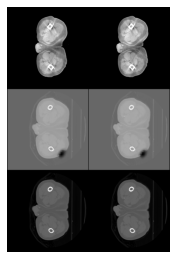

Epoch 0 | ssim : 0.5723037719726562
Epoch 0 | psnr_toB : 23.947505950927734
Epoch 0 | psnr_toA : 14.087447166442871


NameError: name 'model' is not defined

In [17]:
from torch.utils.data import ConcatDataset

cg = CycleGANsformer()
# cg.fit(ImageDatasetLoader(mode="train",transformers=data_transform ))
seta = ImageDatasetLoader(mode="train1",transformers=transforms_)
setb = ImageDatasetLoader(mode="train",transformers=data_transform)
trainset = ConcatDataset([seta, setb])
cg.fit(trainset)

wwwwww

#### 

In [ ]:
# checkpoint_path = './0429lite_checkpoint/0429lite_epoch99.pth'

# # Load the checkpoint
# checkpoint = torch.load(checkpoint_path)

# os.environ["CUDA_VISIBLE_DEVICES"] = '0,1,2,3'
# torch.cuda.set_device(1)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))
# model = TGenerator().to(device)
# # Load the model state_dict from the checkpoint
# model.load_state_dict(checkpoint['self.genX2Y'])

# # Optionally, load other components such as optimizer state_dict or epoch number
# # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# # epoch = checkpoint['epoch']

# # Set the model in evaluation mode
# model.eval()
# with torch.no_grad():
#     fidloader=DataLoader(ImageDatasetLoader(mode="fid",transformers=transforms_ ), batch_size=10, shuffle=False, num_workers=16)
#     fretchet_dist=calculate_fid_score(model,fidloader) 
#     print( f" fid : {fretchet_dist}")  


In [ ]:
import time
# def unnormalize(sample_dicom, x):
#     ds = sample_dicom.copy()
#     slope = ds.RescaleSlope
#     intercept = ds.RescaleIntercept
#     ymin = -200
#     ymax = 1600
#     pixel_min = ymin #/ slope + intercept
#     pixel_max = ymax #/ slope + intercept
# #     normalized_array = np.clip((x + 1) , 0, 2)
# #     mean = np.mean(x)
# #     std = np.std(x)
# #     unnormalized_array = (x * std + mean) * slope + intercept
#     scaled_array = (x)*5-600#(x*0.5+0.5)*100#-500
#     unnormalized_array = (scaled_array - intercept) / slope 
#     return unnormalized_array
def unnormalize(sample_dicom, x):
    ds = sample_dicom.copy()
    slope = ds.RescaleSlope
    intercept = ds.RescaleIntercept
    ymin = -200
    ymax = 1600
    pixel_min = ymin #/ slope + intercept
    pixel_max = ymax #/ slope + intercept

    scaled_array = (x)*6-700
    unnormalized_array = (scaled_array - intercept) / slope 
    return unnormalized_array


def write_dicom(sample_dicom, array, paths, tt):
    ds = sample_dicom.copy()
    ww = ds.WindowWidth
    wc = ds.WindowCenter
    array = np.transpose(array, (2, 1, 0))[:, :, 0]
    array = unnormalize(sample_dicom, array)
    array = np.clip(array, 0, 2 ** 16 - 1)
    ds.PixelData = array.astype(np.uint16).tobytes()
    return ds.save_as(paths + "/" + str(tt) + ".dcm")
checkpoint_path = './0429lite_checkpoint/0429lite_epoch99.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

os.environ["CUDA_VISIBLE_DEVICES"] = '0,1,2,3'
torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))
model = TGenerator().to(device)
# Load the model state_dict from the checkpoint
model.load_state_dict(checkpoint['self.genX2Y'])
model.eval()
with torch.no_grad():
    cbct_count=0
    batch_sizes = 2
    testloader=DataLoader(ImageDatasetLoader(mode="test",transformers=transforms_ ), batch_size=batch_sizes, shuffle=False, num_workers=16, pin_memory=True)
    evlloader=DataLoader(ImageDatasetLoader(mode="evl",transformers=transforms_ ), batch_size=batch_sizes, shuffle=False, num_workers=16, pin_memory=True)

    path="./0429/"+str(98)+"/"
    if not os.path.exists(path):
        os.mkdir(path)
    cbct_data=[]
    for i in range(len(data)):
        ds=pydicom.dcmread(data[i][0],force=True)
        cbct_data.append(ds)
    cbctdata=cbct_data[24000:24704]
#     cbct_data=[]
#     for i in range(len(data)):
#         ds=pydicom.dcmread(data[i][0],force=True)
#         cbct_data.append(ds)

#     indices = [17000, 17010, 17020, 17030, 17040, 17060, 17070, 17080, 17090, 17100,
#            18000, 18100, 18200, 18300, 18400, 18500, 18600, 18700, 18800, 18900, 
#            19000, 19050, 19150, 19250, 19350, 19450, 19550, 19650, 19750, 19850,
#            19950, 20050, 20150, 20250, 20350, 20450, 20550, 20650, 20750, 20850,
#            20950, 22030, 22130, 22230, 22330, 22430, 22530, 22630, 22730, 22830,
#            23070, 23170, 23270, 23370, 23470, 23570, 23670, 23770, 23870, 23970]

#     cbctdata = [cbct_data[i] for i in indices]
    
    start_time = time.time()
    for idx, (a_img, b_img) in enumerate(evlloader):

        model.eval()
        a=a_img.type(torch.cuda.FloatTensor)
        b=b_img.type(torch.cuda.FloatTensor)

        fake_B = model(b,a).detach()
        b = fake_B.cpu().numpy()
        c =b.copy()
        for s in range(len(a_img)):
            t=s+idx*batch_sizes
            write_dicom(cbctdata[t],c[s],path,t)
    end_time = time.time()
    execution_time = end_time - start_time
    print("Execution time:", execution_time, "seconds")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
# Define the directory where the DICOM files are located
directory = "./0429/98/"

# Define the range of DICOM file names you want to load
start_index = 0
end_index = 103

# Initialize a list to store the loaded DICOM datasets
dicom_data = []

# Loop through the range of file names and load each DICOM file
for i in range(start_index, end_index + 1):
    filename = os.path.join(directory, f"{i}.dcm")
    if os.path.exists(filename):
        ds = load_dcm(filename)
        dicom_data.append(ds)
# Replace these with your actual data
scalar_value = 200
scalar_list = [scalar_value] * len(dicom_data)
x1 = np.array([x + scalar_value for x in dicom_data])
x2 = np.array(data_load[24600:24704, 0] + scalar_value)
scalar_value1 = 180
scalar_list1 = [scalar_value1] * len(dicom_data)
y = np.array(data_load[24600:24704, 1]+scalar_list1)

# Reshape y to have a 2-dimensional shape (num_samples, 1)
y = y.reshape(-1, 1)
x1 = x1.reshape(-1, 1)
x2 = x2.reshape(-1, 1)

# Fit linear regression models for y with respect to x1 and x2, setting fit_intercept=False
regressor_x1 = LinearRegression(fit_intercept=False)
regressor_x1.fit(x1, y)

regressor_x2 = LinearRegression(fit_intercept=False)
regressor_x2.fit(x2, y)

# Generate points for the regression lines
x1_line = np.linspace(min(x1), max(x1), 100)
x2_line = np.linspace(min(x2), max(x2), 100)

y_line_x1 = regressor_x1.predict(x1_line.reshape(-1, 1))
y_line_x2 = regressor_x2.predict(x2_line.reshape(-1, 1))
# Plot the linear regression lines
plt.plot(x1_line, y_line_x1, label='Linear Regression (sCT)', color='red')
plt.plot(x2_line, y_line_x2, label='Linear Regression (CBCT)', color='blue')
plt.plot(x1_line, x1_line, label='45-Degree Line', linestyle='dashed', color='green')

plt.xlabel('sCT/CBCT values')
plt.ylabel('planner CT values')
plt.legend()
plt.grid(True)
plt.show()